<a href="https://colab.research.google.com/github/MobinEzzati/GPU-Accelerated-Neural-Network-Training-for-Image-Classification/blob/main/GPU_Accelerated_Neural_Network_Training_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Project Summary

Develop a deep learning image classification model and optimize its training using GPU parallelism. The project will compare performance between CPU and GPU training, showcasing the significant speedup GPU provides. The model will use a publicly available dataset like CIFAR-10 or MNIST. You’ll implement and optimize parts of the neural network using GPU programming techniques to accelerate operations such as matrix multiplications and convolutions.



In [ ]:
!pip install torch torchvision
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pycuda



Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import time
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import time
from sklearn.model_selection import train_test_split
import torch.jit as jit
from torch.profiler import profile, record_function, ProfilerActivity




In [ ]:
!nvidia-smi


Sat Dec  7 04:09:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0              27W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Use Transform fucntion to adjust images to feed them to neural network easier ans smoother

In [ ]:

# Resize images to 28x28 instead of 224x224
# Resize images to 28x28 instead of 28x23
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


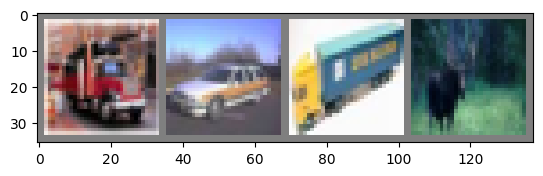

truck car   truck deer 


In [ ]:


# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

 creating our CNN Layer model

In [ ]:


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


This Python script demonstrates how to compare the performance of training a neural network on a CPU versus a GPU using PyTorch. It tracks and visualizes training time, loss, and memory usage over a specified number of epochs

Training on CPU:


<ipython-input-19-6e64a99ff9c4>:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-19-6e64a99ff9c4>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


Epoch [1/5], Loss: 1.6851, Time: 14.35s, Memory Used: 0.00 MB
Epoch [2/5], Loss: 1.3814, Time: 13.43s, Memory Used: 0.00 MB
Epoch [3/5], Loss: 1.2536, Time: 12.29s, Memory Used: 0.00 MB
Epoch [4/5], Loss: 1.1712, Time: 13.50s, Memory Used: 0.00 MB
Epoch [5/5], Loss: 1.1026, Time: 14.18s, Memory Used: 0.00 MB
Training on GPU:
Epoch [1/5], Loss: 1.7302, Time: 5.38s, Memory Used: 21.17 MB
Epoch [2/5], Loss: 1.4302, Time: 7.12s, Memory Used: 20.97 MB
Epoch [3/5], Loss: 1.3146, Time: 5.44s, Memory Used: 20.97 MB
Epoch [4/5], Loss: 1.2238, Time: 6.94s, Memory Used: 20.97 MB
Epoch [5/5], Loss: 1.1573, Time: 5.42s, Memory Used: 20.98 MB


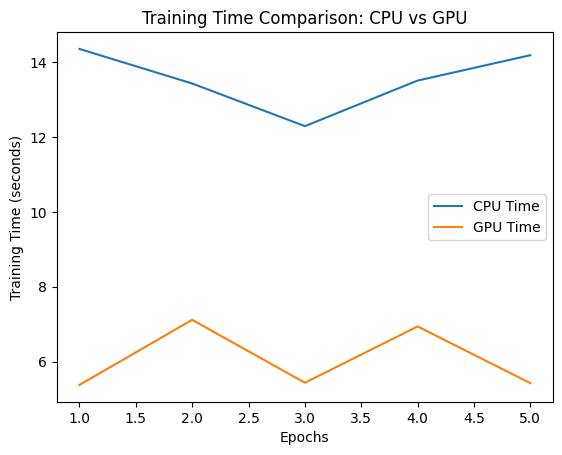

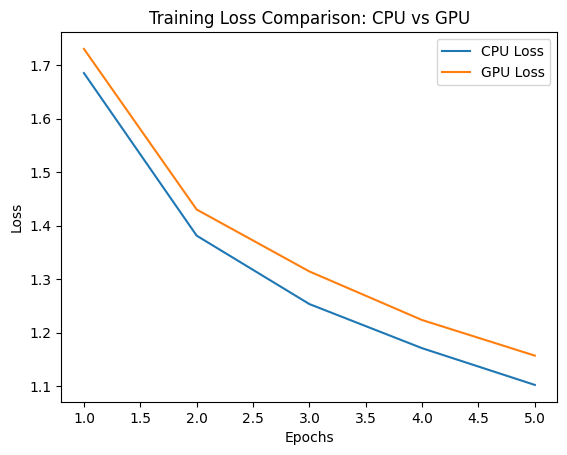

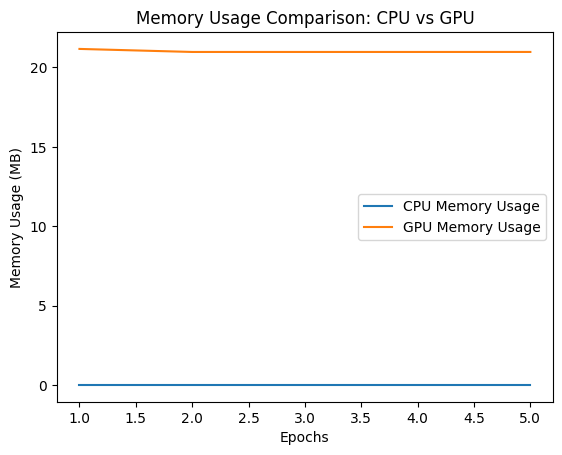

In [ ]:
import torch
import matplotlib.pyplot as plt

# Updated compare_cpu_gpu_training function
def compare_cpu_gpu_training(model_cls, train_loader, loss_fn, optimizer_cls, epochs=5):
    # Initialize CPU model and optimizer
    print("Training on CPU:")
    cpu_model = model_cls().to('cpu')  # Instantiate the model for CPU
    optimizer_cpu = optimizer_cls(cpu_model.parameters(), lr=0.001)
    cpu_metrics = train_model(cpu_model, train_loader, loss_fn, optimizer_cpu, device='cpu', epochs=epochs)

    if torch.cuda.is_available():
        print("Training on GPU:")
        gpu_model = model_cls().to('cuda')  # Instantiate the model for GPU
        optimizer_gpu = optimizer_cls(gpu_model.parameters(), lr=0.001)
        gpu_metrics = train_model(gpu_model, train_loader, loss_fn, optimizer_gpu, device='cuda', epochs=epochs)

        # Plot the training time, loss, and memory usage comparisons
        plot_training_comparison(cpu_metrics, gpu_metrics, epochs)
    else:
        print("CUDA not available for comparison.")

# Function to plot training comparison
def plot_training_comparison(cpu_metrics, gpu_metrics, epochs):
    epochs_range = list(range(1, epochs + 1))

    # Plot training time comparison
    plt.figure()
    plt.plot(epochs_range, cpu_metrics['epoch_times'], label="CPU Time")
    plt.plot(epochs_range, gpu_metrics['epoch_times'], label="GPU Time")
    plt.xlabel("Epochs")
    plt.ylabel("Training Time (seconds)")
    plt.title("Training Time Comparison: CPU vs GPU")
    plt.legend()
    plt.show()

    # Plot training loss comparison
    plt.figure()
    plt.plot(epochs_range, cpu_metrics['epoch_losses'], label="CPU Loss")
    plt.plot(epochs_range, gpu_metrics['epoch_losses'], label="GPU Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Comparison: CPU vs GPU")
    plt.legend()
    plt.show()

    # Plot memory usage comparison
    plt.figure()
    plt.plot(epochs_range, cpu_metrics['epoch_memory_usage'], label="CPU Memory Usage")
    plt.plot(epochs_range, gpu_metrics['epoch_memory_usage'], label="GPU Memory Usage")
    plt.xlabel("Epochs")
    plt.ylabel("Memory Usage (MB)")
    plt.title("Memory Usage Comparison: CPU vs GPU")
    plt.legend()
    plt.show()

# Updated train_model function
def train_model(model, train_loader, loss_fn, optimizer, device, epochs=5):
    model.to(device)  # Move the model to the specified device
    model.train()  # Set the model to training mode

    # Initialize lists to store metrics
    epoch_times = []
    epoch_losses = []
    epoch_memory_usage = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        total_loss = 0.0
        epoch_start_time = time.time()  # Start timer for the epoch

        # Reset peak memory stats (for GPU only)
        if device == 'cuda':
            torch.cuda.reset_peak_memory_stats(device)

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()  # Clear gradients
            with torch.cuda.amp.autocast():  # Enable mixed precision
                pred = model(X)
                loss = loss_fn(pred, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time  # Time per epoch

        # Record peak memory usage (for GPU only)
        memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2) if device == 'cuda' else 0

        # Append metrics
        epoch_times.append(epoch_duration)
        epoch_losses.append(total_loss / len(train_loader))  # Average loss
        epoch_memory_usage.append(memory_used)

        # Print epoch metrics
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_losses[-1]:.4f}, "
              f"Time: {epoch_duration:.2f}s, Memory Used: {memory_used:.2f} MB")

    return {
        "epoch_times": epoch_times,
        "epoch_losses": epoch_losses,
        "epoch_memory_usage": epoch_memory_usage
    }

# Example Usage:
from sklearn.model_selection import train_test_split

# Assuming `Net` is your model class
net = Net

# Split dataset into training and validation sets
train_set, val_set = train_test_split(trainset, test_size=0.2, random_state=42)


# Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam

# Compare CPU and GPU training
compare_cpu_gpu_training(Net, train_loader, criterion, optimizer_cls, epochs=5)




The matrix_mul_shared.cu file contains CUDA code that performs matrix multiplication using shared memory for efficient parallel computation. This implementation is designed to optimize the memory access patterns by leveraging the shared memory within each block on the GPU, significantly improving performance compared to global memory-based approaches.




In [ ]:
%%writefile matrix_mul_shared.cu
#include <cuda_runtime.h>
#include <iostream>

#define BLOCK_SIZE 16

__global__ void matrixMulShared(float* A, float* B, float* C, int N) {
    __shared__ float shared_A[BLOCK_SIZE][BLOCK_SIZE];
    __shared__ float shared_B[BLOCK_SIZE][BLOCK_SIZE];

    int row = blockIdx.y * BLOCK_SIZE + threadIdx.y;
    int col = blockIdx.x * BLOCK_SIZE + threadIdx.x;
    float sum = 0.0;

    for (int i = 0; i < (N + BLOCK_SIZE - 1) / BLOCK_SIZE; ++i) {
        if (row < N && (i * BLOCK_SIZE + threadIdx.x) < N)
            shared_A[threadIdx.y][threadIdx.x] = A[row * N + i * BLOCK_SIZE + threadIdx.x];
        else
            shared_A[threadIdx.y][threadIdx.x] = 0.0;

        if (col < N && (i * BLOCK_SIZE + threadIdx.y) < N)
            shared_B[threadIdx.y][threadIdx.x] = B[(i * BLOCK_SIZE + threadIdx.y) * N + col];
        else
            shared_B[threadIdx.y][threadIdx.x] = 0.0;

        __syncthreads();

        for (int j = 0; j < BLOCK_SIZE; ++j) {
            sum += shared_A[threadIdx.y][j] * shared_B[j][threadIdx.x];
        }
        __syncthreads();
    }

    if (row < N && col < N) {
        C[row * N + col] = sum;
    }
}

int main() {
    const int N = 1024;
    size_t size = N * N * sizeof(float);

    float *h_A = (float*)malloc(size);
    float *h_B = (float*)malloc(size);
    float *h_C = (float*)malloc(size);

    for (int i = 0; i < N * N; ++i) {
        h_A[i] = 1.0f;
        h_B[i] = 1.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, size);
    cudaMalloc(&d_B, size);
    cudaMalloc(&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    dim3 block(BLOCK_SIZE, BLOCK_SIZE);
    dim3 grid((N + BLOCK_SIZE - 1) / BLOCK_SIZE, (N + BLOCK_SIZE - 1) / BLOCK_SIZE);

    matrixMulShared<<<grid, block>>>(d_A, d_B, d_C, N);

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);

    std::cout << "Matrix multiplication completed." << std::endl;

    free(h_A);
    free(h_B);
    free(h_C);
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);

    return 0;
}


Overwriting matrix_mul_shared.cu


In [ ]:
!nvcc matrix_mul_shared.cu -o matrix_mul_shared


In [ ]:
!./matrix_mul_shared
!nvidia-smi


Matrix multiplication completed.
Sat Dec  7 04:23:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              33W /  70W |    313MiB / 15360MiB |      7%      Default |
|                                         |                      |                  N/A |
+----------------------------------